<a href="https://colab.research.google.com/github/lucaszm7/CNC_Aprox_SELAs_Interpol_IntegDiff/blob/main/Lucas_Morais_Relatorio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**


In [ ]:
#Bibliotecas Aqui!
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import *

### Função auxiliar para o plot das funções

In [ ]:
def plot_value_from_interpolation(m, x, y, z, interpol_method, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX', colors=['blue', 'green', 'brown', 'orange', 'red'], extrapol=0):
  
  plt.scatter(x, y, c='black')

  innerpol = min(min(x), min(z))
  extrapol = max(max(x), max(z))

  curva = np.linspace(x[0], extrapol, n_ptos)
  for m_index in range(len(m)):
    valores = [interpol_method(m[m_index], x, y, k, 'value') for k in curva]

    line_label = str(m[m_index]) + ' grau'
    # color=colors[m_index], 
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

In [ ]:
def plot_function_from_interpolation(m, x, y, z, interpol_method, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX', colors=['blue', 'green', 'brown', 'orange', 'red']):
  plt.scatter(x, y, c='black')

  innerpol = min(min(x), min(z))
  extrapol = max(max(x), max(z))

  curva = np.linspace(innerpol, extrapol, n_ptos)

  for m_index in range(len(m)):

    expr = lambdify(symbols('z'), interpol_method(m[m_index], x, y, z[-1], 'function'), 'math')
    valores = [expr(k) for k in curva]
    line_label = (str(m[m_index]) + ' grau - para ' + str(z[-1]))
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

In [ ]:
def plot_spline(x, y, interpol_method, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX'):
  
  plt.scatter(x, y, c='red')

  curva = np.linspace(min(x), max(x), n_ptos)

  for i in range(len(x) - 1):
    expr = lambdify(symbols('x'), interpol_method(x, y)[i], 'math')
    valores = [expr(k) for k in curva]
    line_label = (str(i+1) + ' interval')
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

In [ ]:
def plot_scatter_points(x, y, Xlabel='X', Ylabel='Y', color='cyan', title='Questão XXX'):

  plt.scatter(x, y, c=color)

  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(title)
  plt.grid()

  plt.show()

In [ ]:
def plot_squared_min(x, y, interpol_method, a_type, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX'):
  
  plt.scatter(x, y, c='red')

  curva = np.linspace(min(x), max(x), n_ptos)

  for b_type in a_type:
    expr = lambdify(symbols('x'), interpol_method(x, y, b_type), 'math')
    valores = [expr(k) for k in curva]
    line_label = (b_type)
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

### Funções auxiliares para truncar ou arredondar floats a uma certa precisão

In [ ]:
def truncate(number, decimals):
  factor = int(1 / decimals)
  trunc = math.trunc(number * factor)
  return (trunc / factor)

In [ ]:
def round_epsilon(number, precision):
  n_digits = int(1/precision)
  epsilon = math.log(n_digits, 10)
  return round(number, int(epsilon))

In [ ]:
def round_epsilon_array(number, precision):
  n_digits = int(1/precision)
  epsilon = math.log(n_digits, 10)
  return np.round(number, int(epsilon))

### Função auxiliar para retro substituição

In [ ]:
def retro_substituicao(matriz, b, n, triangular="superior", precisao=None):

  results = np.array([1] * n, dtype=np.float64)

  if triangular == "superior":
    if precisao is not None:
      for i in range( n-1, -1, -1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( n-1, -1, -1 ):
        sum_of_line = np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

  else: # inferior
    if precisao is not None:
      for i in range( 0, n, 1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( 0, n, 1 ):
        sum_of_line = np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

### Classe auxiliar para representação de máquinas

In [ ]:
class Maquina:
  def __init__(self, mantissa, base, menor_expoente, maior_expoente):
    self.mantissa = mantissa
    self.base = mantissa
    self.menor_expoente = menor_expoente
    self.maior_expoente = maior_expoente

## Função auxiliar, Eliminação de Gauss

In [ ]:
def retro_substituicao(matriz, b, n, triangular="superior", precisao=None):

  results = np.array([1] * n, dtype=np.float64)

  if triangular == "superior":
    if precisao is not None:
      for i in range( n-1, -1, -1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( n-1, -1, -1 ):
        sum_of_line = np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

  else: # inferior
    if precisao is not None:
      for i in range( 0, n, 1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( 0, n, 1 ):
        sum_of_line = np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

In [ ]:
def gauss_elimination(matriz, n, pivotamento="nenhum"):

# Escalonamento

  # Vai em todas colunas
  for j in range(0, n):

    # ==========================================================================
    # PIVOTAMENTO TOTAL
    # ==========================================================================
    if pivotamento == "total":
      # Seleciona como pivo o maior elementro da matriz
      maior_elemento = matriz[j][j]
      i_maior_elemento, j_maior_elemento = j, j

      # Vai procurar em toda matriz para encontrar o amior elemento
      for i in range(j, n, 1):
        for j_index in range(j, n, 1):
          if math.fabs(matriz[i][j_index]) > math.fabs(maior_elemento):
            i_maior_elemento, j_maior_elemento = i, j_index
            maior_elemento = matriz[i][j_index]

      # Swap rows
      matriz[[j, i_maior_elemento]] = matriz[[i_maior_elemento, j]]
      # Swap collums
      matriz[: , [j, j_maior_elemento]] = matriz[: , [j_maior_elemento, j]]

      pivo = matriz[j][j]
      if pivo == 0:
        print("Invalid matriz, collum j == 0...")
        return

    # ==========================================================================
    # PIVOTAMENTO PARCIAL
    # ==========================================================================
    elif pivotamento == "parcial":
      # Seleciona como pivo o maior elementro da coluna j
      # print("Matriz: \n", matriz)
      maior_elemento = matriz[j][j]
      for i in range(j+1, n, 1):
        # print("Maior elemento: ", maior_elemento)
        # print("Matriz[i][j]: ", matriz[i][j])
        if  math.fabs(matriz[i][j]) > math.fabs(maior_elemento):
          # Swap linha com maior elemento
          matriz[[i, j]] = matriz[[j, i]]
          # print("Matriz swapped: \n", matriz)
          maior_elemento = matriz[j][j]
    
      pivo = matriz[j][j]
      # print("Pivo: ", pivo)
      if pivo == 0:
        print("Invalid matriz, collum j == 0...")
        return

    # ==========================================================================
    # SEM PIVOTAMENTO
    # ==========================================================================
    elif pivotamento == "nenhum":
      # Seleciona pivo
      pivo = matriz[j][j]
      # print("pivo == ", pivo)
      # Swap com a próxima linha até pivo != 0
      index_pivo = j + 1
      while pivo == 0:
        # print("pivo == 0, swapping rows")
        matriz[[j, index_pivo]] = matriz[[index_pivo, j]]
        # print("Matrix swapped\n", matriz)
        pivo = matriz[j][j]
        # print("new pivo = ", pivo)
        index_pivo += 1
        if index_pivo > n:
          print("Invalid matriz...")
          return

    # pivotamento errado
    else:
      print("invalid pivotamento...")
      return

    # ==========================================================================
    # Constroi linha L'
    # Vai da linha j até a ultima
    for i in range(j+1, n):
      # Multiplicador da linha i
      m = matriz[i][j] / pivo
      # Linha L'i
      matriz[i] = matriz[i] - m * matriz[j]


# Retro Substituição

  # Pega b (os resultados)
  # fazendo a transposta da matriz
  b = matriz.T[n]

  # Retira a ultima coluna dos resultados
  matriz = matriz[0:n+1][0:n]

  # Cria o array (de tamanho n) que sera armazenado os resultados
  results = np.array([1] * n, dtype=np.float64)

  # Vai da ultima inha até a primeira
  for i in range( n-1, -1, -1 ):
      sum_of_line = np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64)
      results[i] = (b[i] - sum_of_line) / matriz[i][i]

  return (matriz, results)

### Erro absoluto

In [ ]:
def erro_abs_porcen(r_analitica, r_aprox):
  erro_abs = r_analitica - r_aprox
  erro_porcen = 100 * (erro_abs / r_analitica)
  return erro_porcen

# **Métodos**

## Regra do Trapézio

In [ ]:
# Regra do trapézio
def trapezio(f, a, b):
  return  ((b - a)/2) * (f(b) + f(a))

In [ ]:
# Teste trapézio
f = lambda x: math.sqrt(4 - ((x - 3)**2))
trapezio(f, 1, 3)

2.0

In [ ]:
# Regra do trapézio repetido
def trapezio_repetido(f, a, b, m):

  h = (b - a)/m
  sum = 0
  integration = 0

  for i in range(0, m):
    integration += trapezio(f, a + (i*h), a + ((i*h)+h))

  error = -m * (h**3)/12 * f(b)
  return integration


In [ ]:
# Teste trapézio repetido
f = lambda x: math.sqrt(4 - ((x - 3)**2))
trapezio_repetido(f, 1, 3, 8)

3.0898191443571736

## Regra de 1/3 de Simpson

In [ ]:
# Regra de 1/3 de simpson
def simpson_1_3(f, a, b):
  h = (b - a)/2
  return  (h/3) * (f(a) + 4*f(a+h) + f(b))

In [ ]:
# Teste simpson
f = lambda x: x**4
simpson_1_3(f, 1, 5)

633.3333333333333

In [ ]:
# Regra de 1/3 de simpson repetido
# Funcao F(x), de a, até b, com m intervalos
def simpson_1_3_repetido(f, a, b, m):
  h = (b - a)/m
  sum = 0
  integration = 0

  for i in range(0, m):
    integration += simpson_1_3(f, a + (i*h), a + ((i*h)+h))

  error = -(m/2) * (h**5)/90 * f(b)
  return integration

In [ ]:
# Teste simpson repetido
f = lambda x: x**4
simpson_1_3_repetido(f, 1, 5, 2)

625.3333333333333

## Regra de 3/8 de Simpson

In [ ]:
# Regra de 3/8 de simpson
def simpson_3_8(f, a, b):
  h = (b - a)/3
  return  (h*3/8) * (f(a) + 3*f(a+h) + 3*f(a+(2*h)) + f(b))

In [ ]:
# Teste 3/8 de simpson
f = lambda x: 1/x
simpson_3_8(f, 1, 3)

1.1047619047619048

In [ ]:
# Regra de 3/8 de simpson repetido
# Funcao F(x), de a, até b, com m intervalos
def simpson_3_8_repetido(f, a, b, m):
  h = (b - a)/m
  sum = 0
  integration = 0

  for i in range(0, m):
    integration += simpson_3_8(f, a + (i*h), a + ((i*h)+h))

  error = -(m/3) * (h**5) * (3/80) * f(b)
  return integration

In [ ]:
# Teste 3/8 de simpson repetido
f = lambda x: 2.71828**x
simpson_3_8_repetido(f, 0, 1, 1)

1.718539479920413

## Diferenças centradas

In [ ]:
def diff_1_centrada(f, x, h, o):
  if o == 2:
    return ( f(x+h) - f(x-h) ) / ( 2*h )
  elif o == 4:
    return ( -f(x+(2*h)) + 8*f(x+h) - 8*f(x-h) + f(x-(2*h)) ) / ( 12*h )
  else:
    raise ValueError('Invalid O')


In [ ]:
# Teste 1 derivada centrada
f = lambda x: -0.1*(x**4) -0.15*(x**3) - 0.5*(x**2) - 0.25*x + 1.2
diff_1_centrada(f, 0.5, 0.25, 2)

-0.9343750000000002

In [ ]:
def diff_2_centrada(f, x, h, o):
  if o == 2:
    return ( f(x+h) - 2*f(x) + f(x-h) ) / ( h**2 )
  elif o == 4:
    return ( - f(x+(2*h)) + 16*f(x+h) - 30*f(x) + 16*f(x-h) - f(x-(2*h)) ) / ( 12*(h**2) )
  else:
    raise ValueError('Invalid O')


In [ ]:
# Teste 2 derivada centrada
f = lambda x: x**2
diff_2_centrada(f, 2, 0.1, 2)

2.0000000000000013

# **Relatório 4**


##Questão 1 –
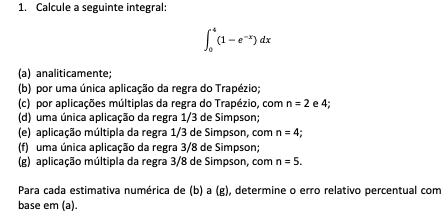



In [ ]:
f = lambda x: 1 - (math.e ** -x)

#### a)

De forma analitica temos que:
$$ 
\int_0^4 (1 - e^{-x})\; dx = \left| x + e^{-x} \right|_0^4 ≈ 3.0183 
$$

In [ ]:
r_analitica = 3.0183

#### b)

Com uma única aplicação da regra do trapézio, formamos um trapézio para tentar aproximar a função, e calculamos a área desse trapézio pela formula

$
\mathrm{Area} = \frac{h}{2}  {(f(b) + f(a))}
$

Lógicamente estamos cometendo um erro aqui, mas veremos formas melhores a seguir.

In [ ]:
r_a = trapezio(f, 0, 4)
print(r_a)

1.9633687222225316


In [ ]:
# Erro
erro_abs = r_analitica - r_a
erro_porcen = 100 * (erro_abs / r_analitica)
print(erro_porcen, "%")

34.95117376594336 %


#### c)

Para $m = 2$ e $m = 4$, no caso, subdividimos o intervalo $[0, 4]$ em ${2}$ e ${4}$ partes.

$
h = \frac{b-a}{m}, \\ \frac{4-0}{2} = 2, \\ \frac{4-0}{4} = 1 
$

E calculamos individualmente a área de cada trapézio e somamos

$
\frac{h}{2}\sum_{i=0}^{m} {f(x_i) + f(x_{i+1})}
$



In [ ]:
r_b_1 = trapezio_repetido(f, 0, 4, 2)
print(r_b_1)

2.71101379463804


In [ ]:
# Erro
erro_abs = r_analitica - r_b_1
erro_porcen = 100 * (erro_abs / r_analitica)
print(erro_porcen, "%")

10.180770810123574 %


In [ ]:
r_b_2 = trapezio_repetido(f, 0, 4, 4)
print(r_b_2)

2.9378403877797137


In [ ]:
# Erro
erro_abs = r_analitica - r_b_2
erro_porcen = 100 * (erro_abs / r_analitica)
print(erro_porcen, "%")

2.6657261445279232 %


#### d)

Na regra de 1/3 de Simpson, ao contrário da regra do trapézio, agora fazemos a aproximação por um polinômio de grau 2, então precisamos de 3 pontos.

Isso leva a uma aproximação mais fiel e condinzente, com um erro menor que a regra do trapézio.

In [ ]:
r_d = simpson_1_3(f, 0, 4)
print(r_d)

2.9602288187765433


In [ ]:
# Erro
erro_abs = r_analitica - r_d
erro_porcen = 100 * (erro_abs / r_analitica)
print(erro_porcen, "%")

1.9239698248503019 %


#### e)
Quando fazemos a forma repetida, implementei da seguinte forma

 Ex.: $\int_0^4 f(x)\;dx$ para 2 intervalos, primeiro dividimos o intervalo $[0, 4]$ em 2 subintervalos igualmente espaçados, $h = 2$ - $[0,2]$ e $[2,4]$ e então calculamos cada subintervalo individualmente, logo, após dividirmos o intervalo $[0,4]$ em 2, quando calcularmos a área do subintervalo, o subdividiremos outra vez para termos os 3 pontos necessários, $[0,2] => (0, 1, 2)$. Então no final teremos 4 intervalos.

In [ ]:
r_e = simpson_1_3_repetido(f, 0, 4, 4)
print(r_e)

3.0179846613217176


In [ ]:
# Erro
erro_abs = r_analitica - r_e
erro_porcen = 100 * (erro_abs / r_analitica)
print(erro_porcen, "%")

0.010447559165171556 %


#### f)
Analogamente, a forma 3/8 de simpson utiliza agora um polinômio de grau 3, logo, precisamos de 4 pontos.

Levando também a uma melhor aproximação em relação ao método anterior 1/3 de simpson.

In [ ]:
r_f = simpson_3_8(f, 0, 4)
print(r_f)

2.9912212965478404


In [ ]:
# Erro
erro_abs = r_analitica - r_f
erro_porcen = 100 * (erro_abs / r_analitica)
print(erro_porcen, "%")

0.8971508283523696 %


#### g)

A forma repetida de 3/8 de simpson foi implementada seguindo a mesma lógica da 1/3 de simpson, onde subdividimos primeiro o intervalo inteiro, e então subdividimos cada subintervalo para fazermos os cálculos.

In [ ]:
r_g = simpson_3_8_repetido(f, 0, 4, 5)
print(r_g)

3.018254620633804


In [ ]:
# Erro
erro_abs = r_analitica - r_g
erro_porcen = 100 * (erro_abs / r_analitica)
print(erro_porcen, "%")

0.0015034743463493844 %


##Questão 2 –
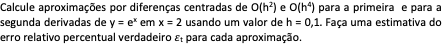

Analisando $y = e^{x}$ de forma analitica, temos:
$
f(x) = e^{x} \\
f'(x) = e^{x} \\ 
f''(x) = e^{x} \\
f^{n}(2) = e^{2} = 7.389056098930650
$

In [ ]:
r_analitica = 7.389056098930650

In [ ]:
f = lambda x: (math.e)**x

In [ ]:
r_1_2 = diff_1_centrada(f, 2, 0.1, 2)
print(f'1 Derivada O(2) = {r_1_2}')
print(f'Erro percentural = {abs(erro_abs_porcen(r_analitica, r_1_2))}%')

1 Derivada O(2) = 7.401377351441907
Erro percentural = 0.1667500198440707%


In [ ]:
r_1_4 = diff_1_centrada(f, 2, 0.1, 4)
print(f'1 Derivada O(4) = {r_1_4}')
print(f'Erro percentural = {abs(erro_abs_porcen(r_analitica, r_1_4))}%')

1 Derivada O(4) = 7.389031439404893
Erro percentural = 0.0003337303902853473%


In [ ]:
r_2_2 = diff_2_centrada(f, 2, 0.1, 2)
print(f'2 Derivada O(2) = {r_2_2}')
print(f'Erro percentural = {abs(erro_abs_porcen(r_analitica, r_2_2))}%')

2 Derivada O(2) = 7.395215698561939
Erro percentural = 0.08336111607246144%


In [ ]:
r_2_4 = diff_2_centrada(f, 2, 0.1, 4)
print(f'2 Derivada O(4) = {r_2_4}')
print(f'Erro percentural = {abs(erro_abs_porcen(r_analitica, r_2_4))}%')

2 Derivada O(4) = 7.389047881534545
Erro percentural = 0.00011121036294447801%


### Resposta questão 2

Os resultados foram como previstos, onde as formas com maior acurácia (O(4)) obtiveram um menor erro percentual